## Perturbative footprint study: footprints clustering

### Imports

In [1]:
# Import standard modules
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import MeanShift, estimate_bandwidth

# Nicer style
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set_palette('tab20', color_codes=True)
%config InlineBackend.figure_format='retina'


### Load footprints and plot a sample

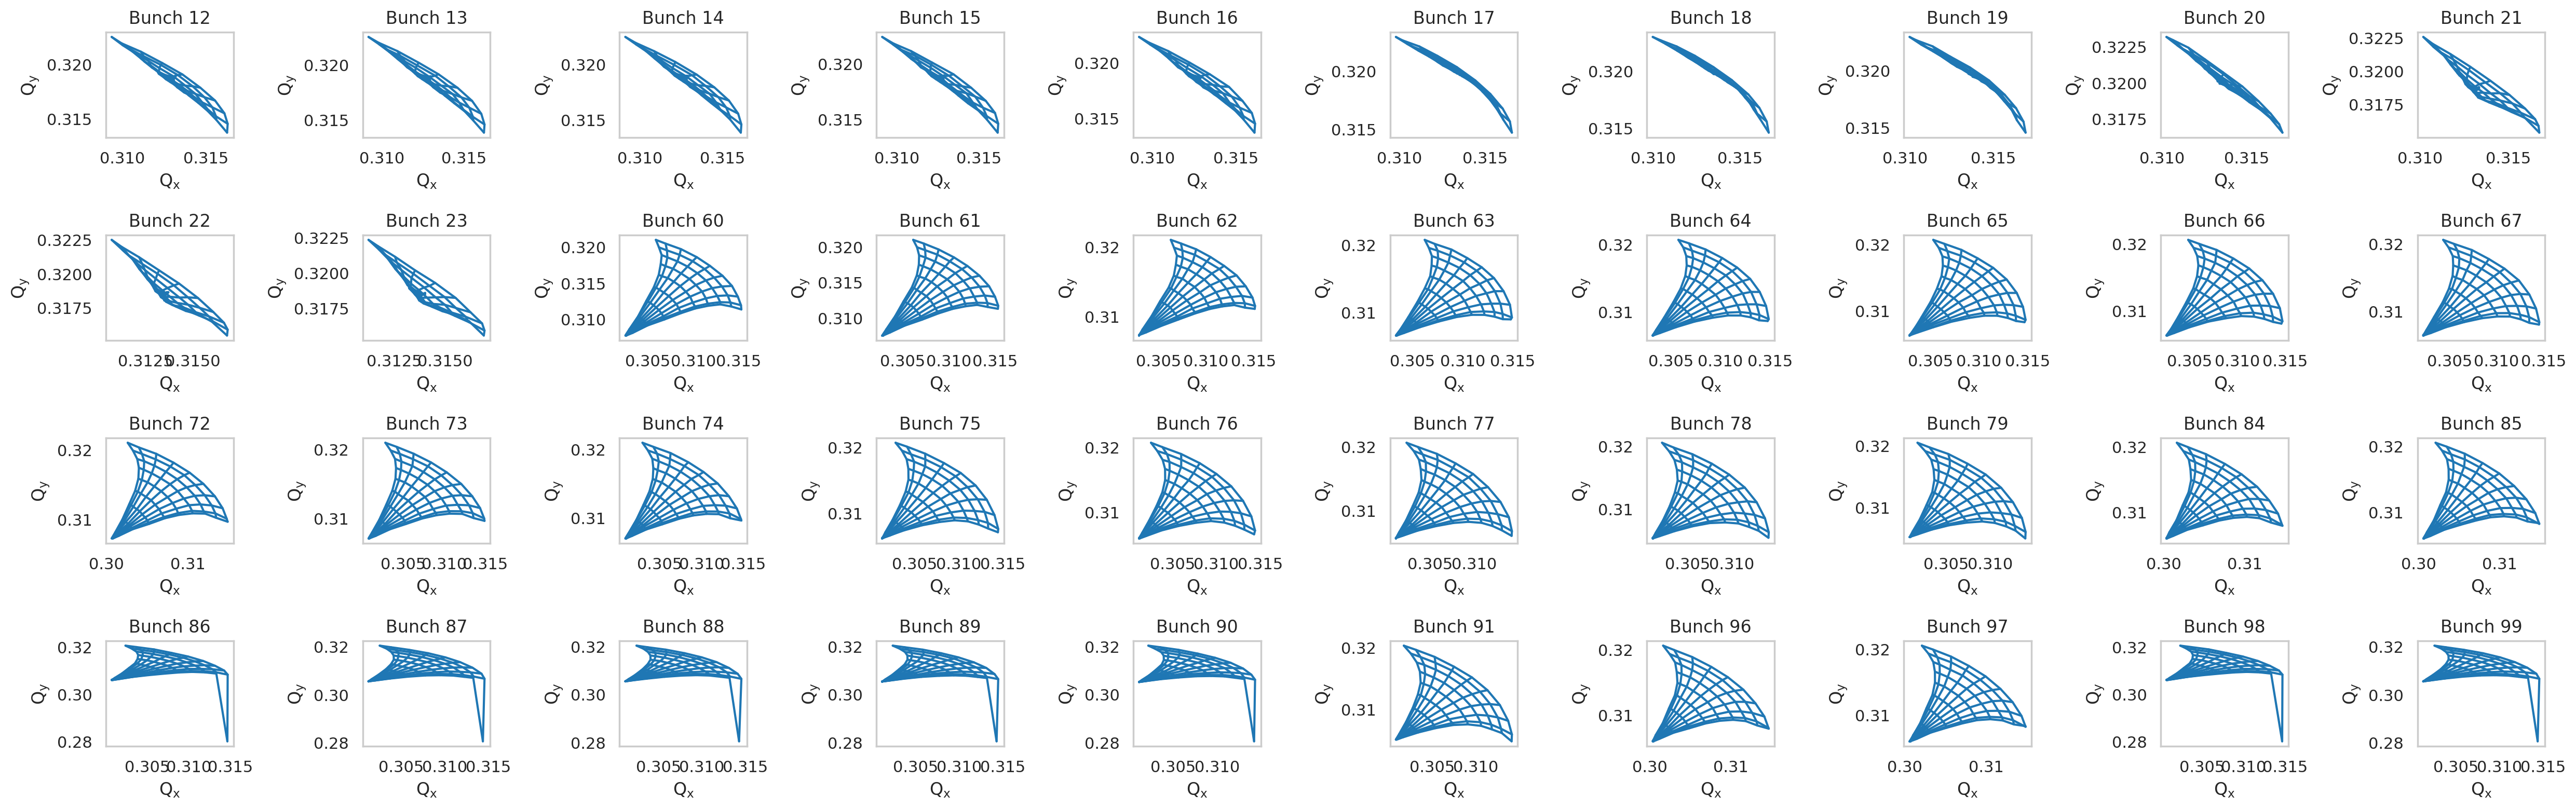

In [2]:
# Load l_fp
with open("output/l_fp.pkl", "rb") as f:
    l_fp = pickle.load(f)

# Load list of bunch numbers
with open("output/l_bunch_nb.pkl", "rb") as f:
    l_bunch_nb = pickle.load(f)

# Remove all nan footprints, along with bunch numbers
#l_bunch_nb = [bunch_nb for i, bunch_nb in enumerate(l_bunch_nb) if not np.isnan(l_fp[i]).any()]
#l_fp = [fp for fp in l_fp if not np.isnan(fp).any()]


# Make a grid of plots for all the footprints
sample_nb = 40
n_cols = 10
n_rows = int(np.ceil(len(l_fp[:sample_nb])/n_cols))
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*2.5, n_rows*2))
for i, fp in enumerate(l_fp[:sample_nb]):
    try:
        ax = axs[i//n_cols, i%n_cols]
        ax.plot(fp[0], fp[1], color="C0")
        ax.plot(fp[0].T, fp[1].T, color="C0")
        ax.set_title(f"Bunch {l_bunch_nb[i]}")
        ax.set_xlabel(r"$\mathrm{Q_x}$")
        ax.set_ylabel(r"$\mathrm{Q_y}$")
        #ax.set_aspect("equal")
        ax.set_title(f"Bunch {l_bunch_nb[i]}")
        ax.grid()
    except:
        pass

plt.tight_layout()
plt.show()

### Remove outliers in each figure

In [3]:
# Look for outlier index in Qy distribution
l_qy = [fp[1] for fp in l_fp]
for i, qy in enumerate(l_qy):
    if np.min(qy) < 0.29:
        # Get outlier coordinates in 2D
        arg_outlier_flat = np.argmin(qy)
        print(f"Outlier found at index {i} (bunch {l_bunch_nb[i]}).")
        if i>80:
            break

# Clearly, there's a recurring outlier. Create a copy of fp where it's been replaced by nan
l_fp_no_outlier = [fp.copy() for fp in l_fp]
for i, fp in enumerate(l_fp_no_outlier):
    l_fp_no_outlier[i][0].flat[arg_outlier_flat] = np.nan
    l_fp_no_outlier[i][1].flat[arg_outlier_flat] = np.nan




Outlier found at index 30 (bunch 86).
Outlier found at index 31 (bunch 87).
Outlier found at index 32 (bunch 88).
Outlier found at index 33 (bunch 89).
Outlier found at index 34 (bunch 90).
Outlier found at index 38 (bunch 98).
Outlier found at index 39 (bunch 99).
Outlier found at index 40 (bunch 100).
Outlier found at index 41 (bunch 101).
Outlier found at index 42 (bunch 102).
Outlier found at index 46 (bunch 110).
Outlier found at index 47 (bunch 111).
Outlier found at index 48 (bunch 112).
Outlier found at index 49 (bunch 113).
Outlier found at index 50 (bunch 114).
Outlier found at index 56 (bunch 124).
Outlier found at index 57 (bunch 125).
Outlier found at index 86 (bunch 173).


### Get DA for each footprint and plot

In [4]:
# Load dataframe for DA
path = "/afs/cern.ch/work/c/cdroin/private/DA_study/master_study/opt_flathv_75_1500_withBB_chroma15_1p4_all_bunches"
df = pd.read_parquet(f"{path}/da.parquet")

# Round all numbers to 3 decimals
df = df.round(3)

# Get list of bunches and list of DA
l_bunch_nb_from_DA = df["bunch_nb"]
l_DA = df["normalized amplitude in xy-plane"]
dic_DA = {bunch_nb: DA for bunch_nb, DA in zip(l_bunch_nb_from_DA, l_DA)}

In [5]:
# Check that the bunch numbers are the same
assert all(l_bunch_nb_from_DA) == all(l_bunch_nb)

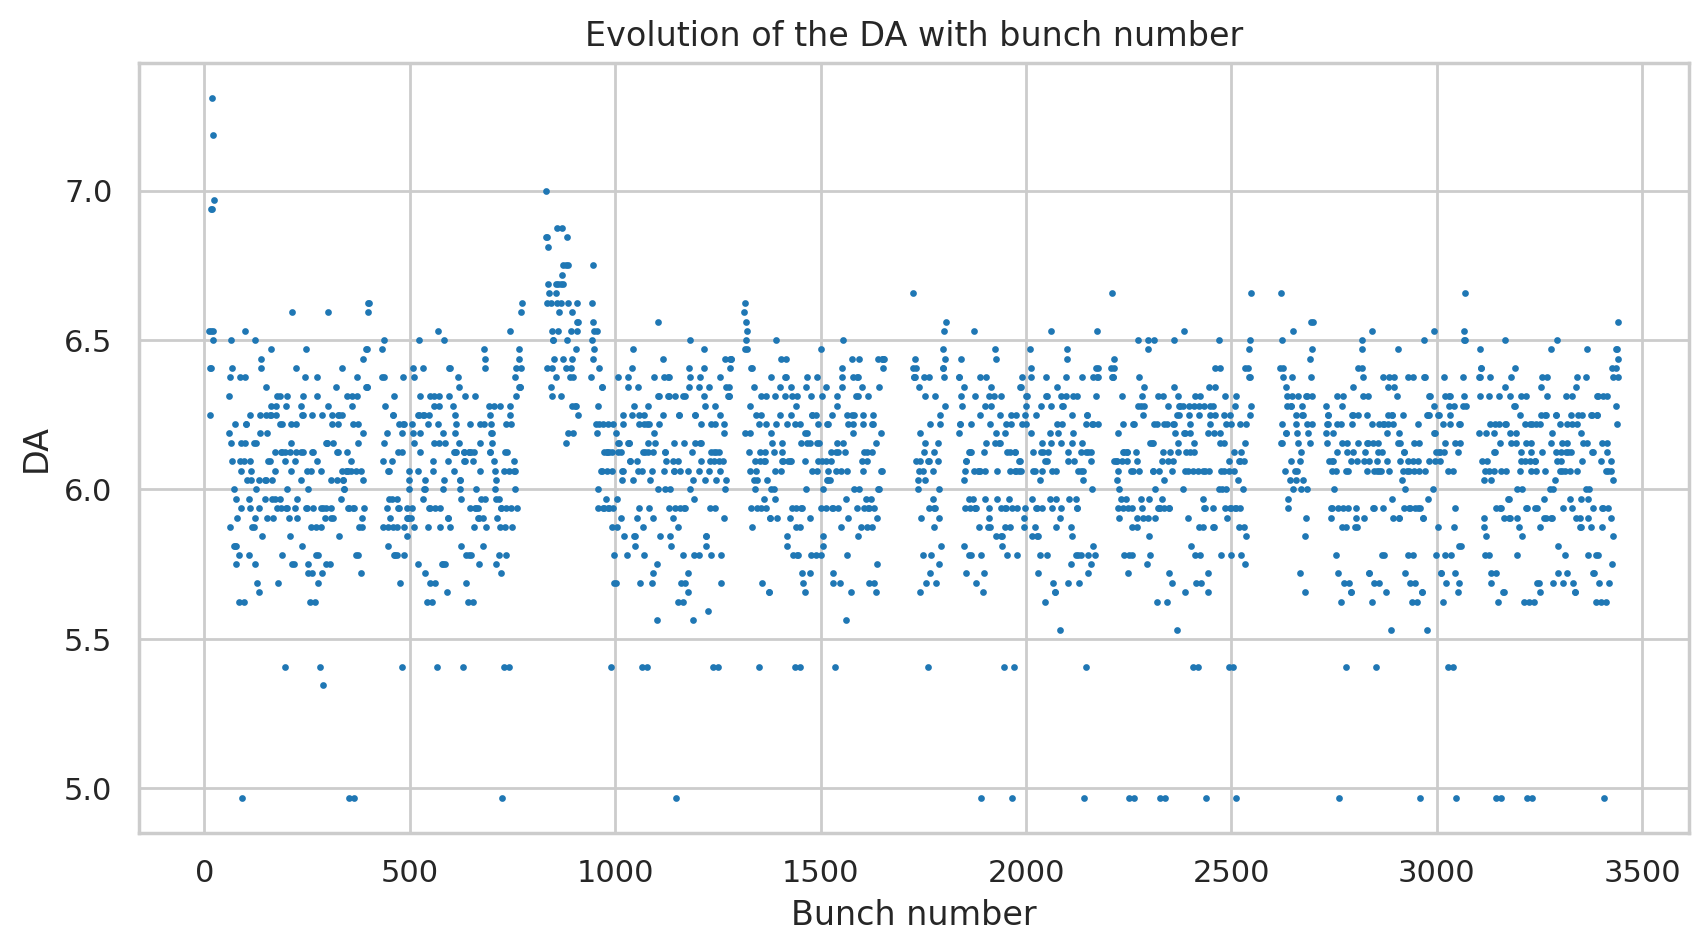

6.25


In [6]:
# Plot DA vs bunch number
plt.figure(figsize=(10, 5))
plt.scatter(l_bunch_nb, [dic_DA[bunch_nb] for bunch_nb in l_bunch_nb], s = 2)
plt.xlabel("Bunch number")
plt.ylabel("DA")
plt.title("Evolution of the DA with bunch number")
plt.savefig("PDF_output/DA_vs_bunch_nb.pdf")
plt.show()


print(dic_DA[1963])

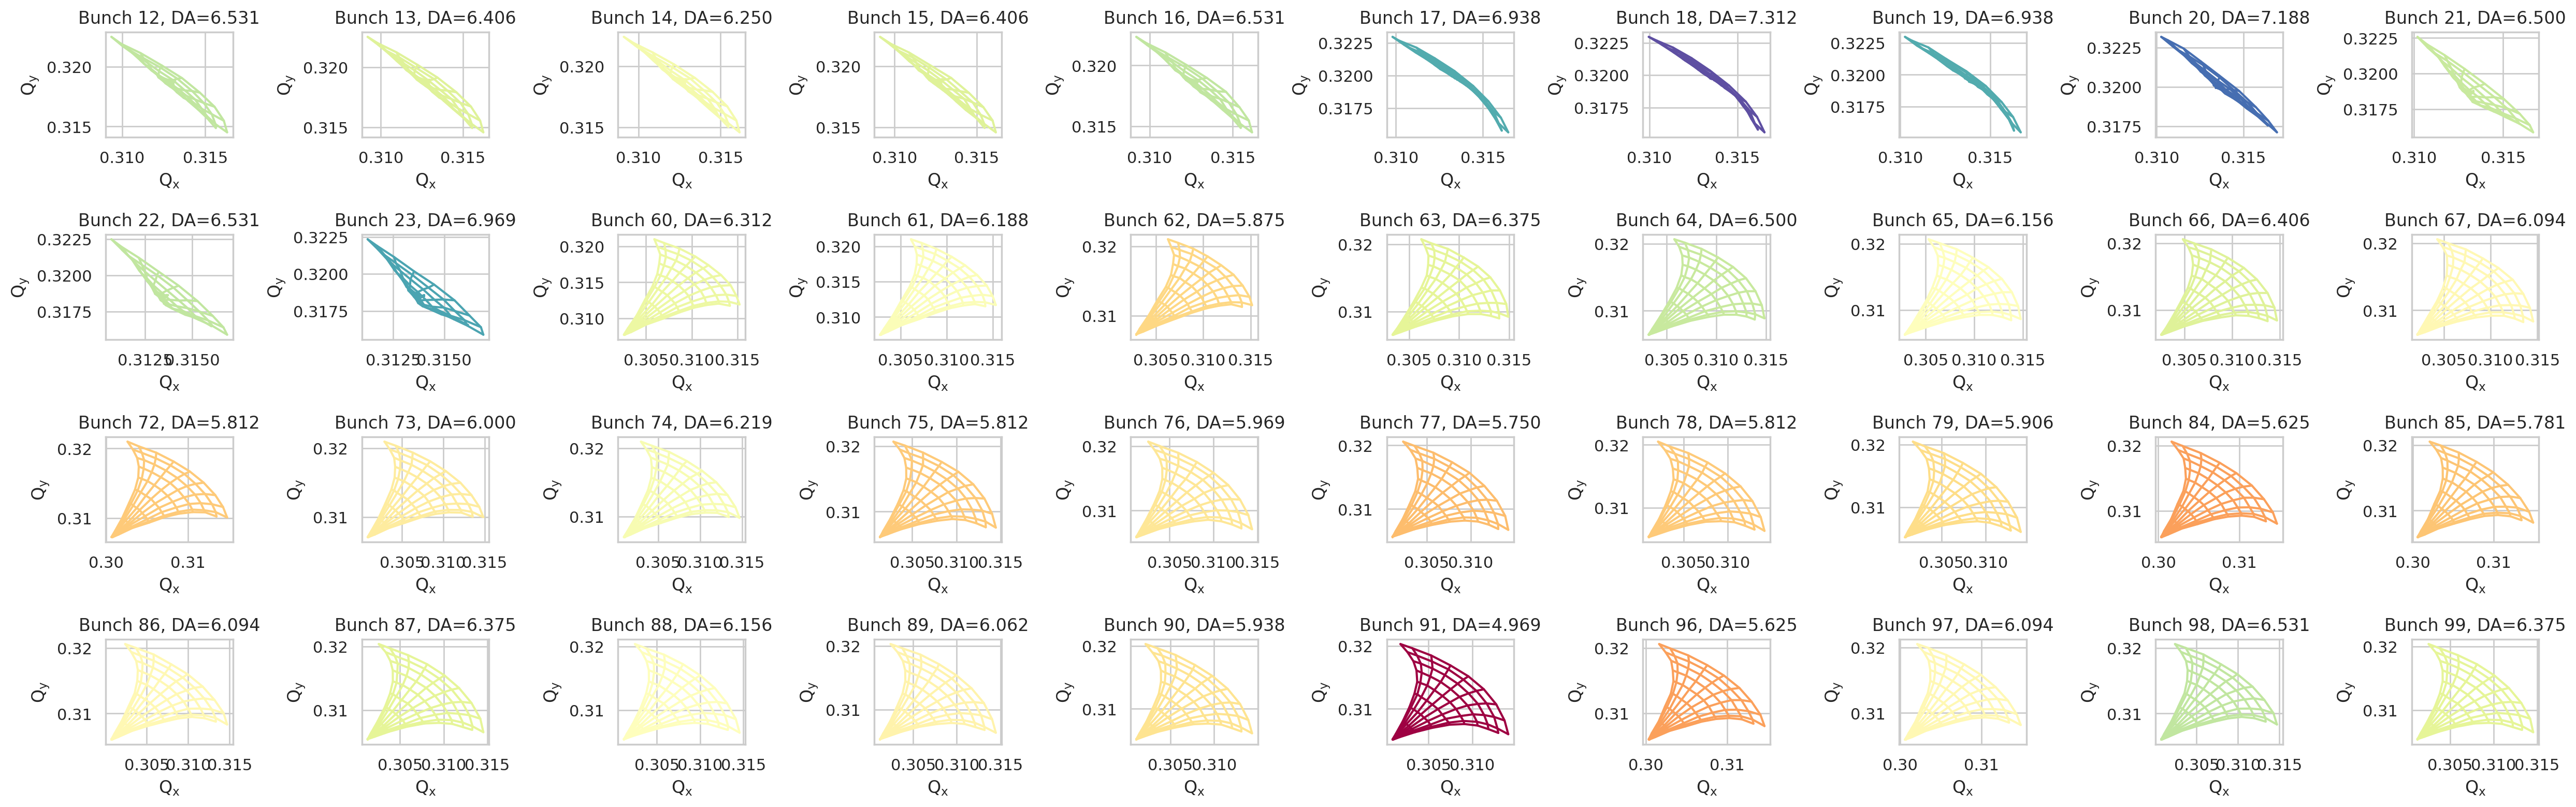

In [7]:
# Make a grid of plots for all the footprints
n_cols = 10
n_rows = int(np.ceil(len(l_fp_no_outlier[:sample_nb])/n_cols))
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*2.5, n_rows*2))

# Build a discrete colormap for DAs
min_DA = np.min(l_DA)
max_DA = np.max(l_DA)
discrete_cmap = sns.color_palette("Spectral", n_colors=256)
l_colors = [discrete_cmap[int((DA-min_DA)/(max_DA-min_DA)*255)] for DA in l_DA]
dic_colors = {bunch_nb: color for bunch_nb, color in zip(l_bunch_nb_from_DA, l_colors)}

for i, (bunch_nb, fp) in enumerate(zip(l_bunch_nb[:sample_nb], l_fp_no_outlier[:sample_nb])):
    try:
        ax = axs[i//n_cols, i%n_cols]
        ax.plot(fp[0], fp[1], color=dic_colors[l_bunch_nb[i]])
        ax.plot(fp[0].T, fp[1].T, color=dic_colors[l_bunch_nb[i]])
        ax.set_title(f"Bunch {l_bunch_nb[i]}, DA={dic_DA[l_bunch_nb[i]]:.3f}")
        ax.set_xlabel(r"$\mathrm{Q_x}$")
        ax.set_ylabel(r"$\mathrm{Q_y}$")
        #ax.set_aspect("equal")
        ax.set_xlim(np.min(fp[0])-0.01, np.max(fp[0])+0.01)
        ax.set_ylim(np.min(fp[1])-0.01, np.max(fp[1])+0.01)
        ax.set_title(f"Bunch {l_bunch_nb[i]}")
        ax.grid()
    except:
        pass

plt.tight_layout()
plt.show()

### Reduce dimensionality with PCA

In [8]:
# Convert matrix samples to a row
l_fp_flat = []
for i, fp in enumerate(l_fp):
    # Process qx and qy separately
    fp_x = fp[0].flatten()
    fp_y = fp[1].flatten()

    # Remove outlier
    fp_x_deleted = np.delete(fp_x, arg_outlier_flat)
    fp_y_deleted = np.delete(fp_y, arg_outlier_flat)
    # Replace by nan
    #fp_x_deleted = np.insert(fp_x_deleted, arg_outlier_flat, 0.3)
    #fp_y_deleted = np.insert(fp_y_deleted, arg_outlier_flat, 0.3)
    
    l_fp_flat.append([fp_x_deleted, fp_y_deleted])
    #l_fp_flat.append([fp_x, fp_y])
array_fp_flat = np.array(l_fp_flat)

# apply tsne to the data: rebuild the 2D matrix with only 1 components for each tune dimension
pca = PCA(n_components=5)
#pca = umap.UMAP(random_state=42)

array_fp_flat_qx_ld = pca.fit_transform(array_fp_flat[:,0,:])
array_fp_flat_qx_compressed = pca.inverse_transform(array_fp_flat_qx_ld)
array_fp_flat_qy_ld = pca.fit_transform(array_fp_flat[:,1,:])
array_fp_flat_qy_compressed = pca.inverse_transform(array_fp_flat_qy_ld)

# Insert np.nan for outlier and reshape compressed arrays to original shape
array_fp_flat_qx_compressed = np.insert(array_fp_flat_qx_compressed, arg_outlier_flat, np.nan, axis = -1)
array_fp_flat_qy_compressed = np.insert(array_fp_flat_qy_compressed, arg_outlier_flat, np.nan, axis = -1)
array_fp_flat_qx_compressed = np.reshape(array_fp_flat_qx_compressed, (array_fp_flat_qx_compressed.shape[0], l_fp[0][0].shape[0], l_fp[0][0].shape[1]))
array_fp_flat_qy_compressed = np.reshape(array_fp_flat_qy_compressed, (array_fp_flat_qy_compressed.shape[0], l_fp[0][1].shape[0], l_fp[0][1].shape[1]))
array_fp_flat_compressed = np.array([array_fp_flat_qx_compressed, array_fp_flat_qy_compressed])

# switch dimension 0 and 1
array_fp_compressed = np.swapaxes(array_fp_flat_compressed, 0, 1)

print(array_fp_compressed.shape)

(1972, 2, 10, 10)


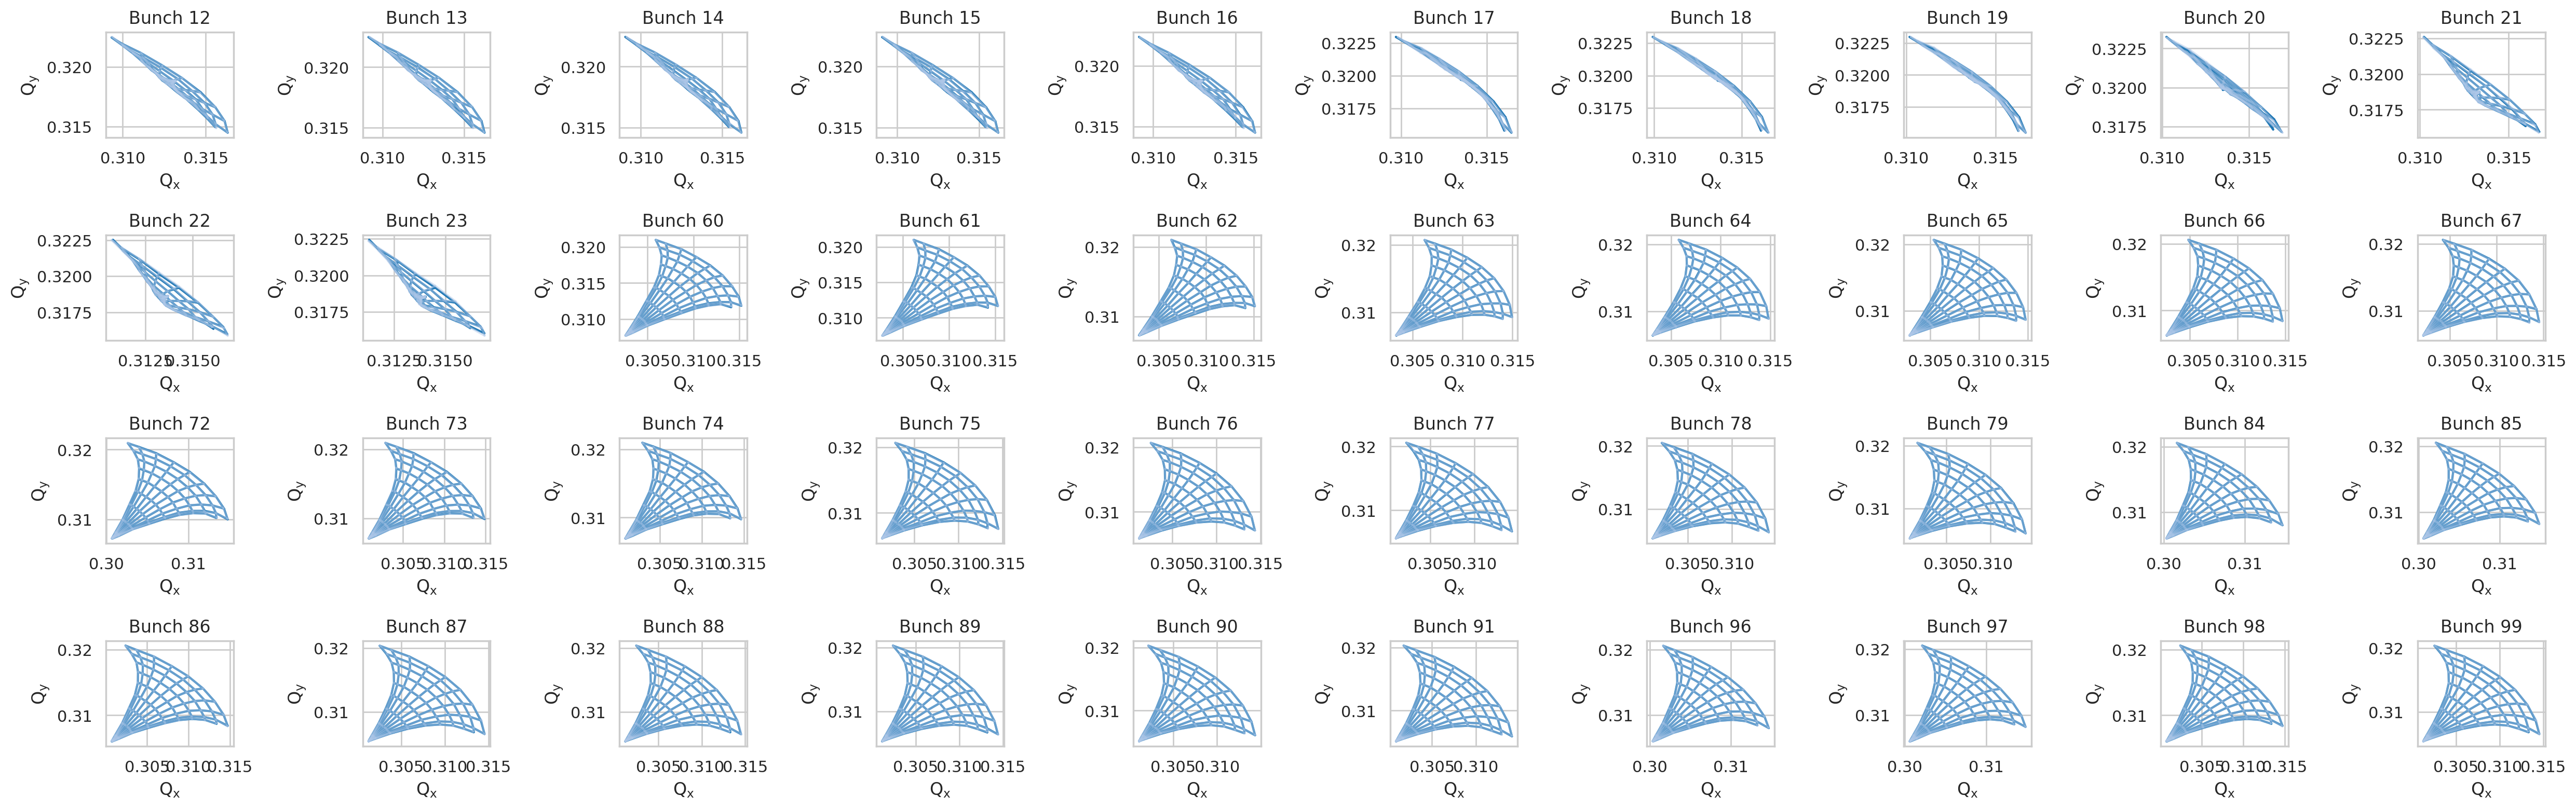

In [9]:
# Make a grid of plots for all the footprints
n_cols = 10
n_rows = int(np.ceil(len(l_fp_no_outlier[:sample_nb])/n_cols))
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*2.5, n_rows*2))
for i, (fp_compressed, fp_original) in enumerate(zip(array_fp_compressed[:sample_nb], l_fp_no_outlier[:sample_nb])):
    try:
        ax = axs[i//n_cols, i%n_cols]
        ax.plot(fp_compressed[0], fp_compressed[1], color="C0")
        ax.plot(fp_compressed[0].T, fp_compressed[1].T, color="C0")
        ax.plot(fp_original[0], fp_original[1], color="C1", alpha = 0.5)
        ax.plot(fp_original[0].T, fp_original[1].T, color="C1", alpha = 0.5)
        ax.set_title(f"Bunch {l_bunch_nb[i]}")
        ax.set_xlabel(r"$\mathrm{Q_x}$")
        ax.set_ylabel(r"$\mathrm{Q_y}$")
        #ax.set_aspect("equal")
        ax.set_xlim(np.min(fp_original[0])-0.01, np.max(fp_original[0])+0.01)
        ax.set_ylim(np.min(fp_original[1])-0.01, np.max(fp_original[1])+0.01)
        ax.set_title(f"Bunch {l_bunch_nb[i]}")
        ax.grid()
    except:
        pass

plt.tight_layout()
plt.savefig("output/footprints_compressed.png")
#plt.show()

### Cluster the resulting points

In [10]:
# Get 4D data
array_fp_ld = np.hstack([array_fp_flat_qx_ld, array_fp_flat_qy_ld])

# Apply HDBSCAN
#clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=10).fit(array_fp_ld)
#
bandwidth = estimate_bandwidth(array_fp_ld, quantile=0.13, n_samples=len(array_fp_ld))
clusterer = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit(array_fp_ld)

# Get number of bunches in each cluster
l_cluster_nb = []
for i in range(np.max(clusterer.labels_)+1):
    l_cluster_nb.append(np.sum(clusterer.labels_ == i))
print(l_cluster_nb)


[1026, 702, 57, 56, 64, 28, 14, 13, 5, 4, 3]


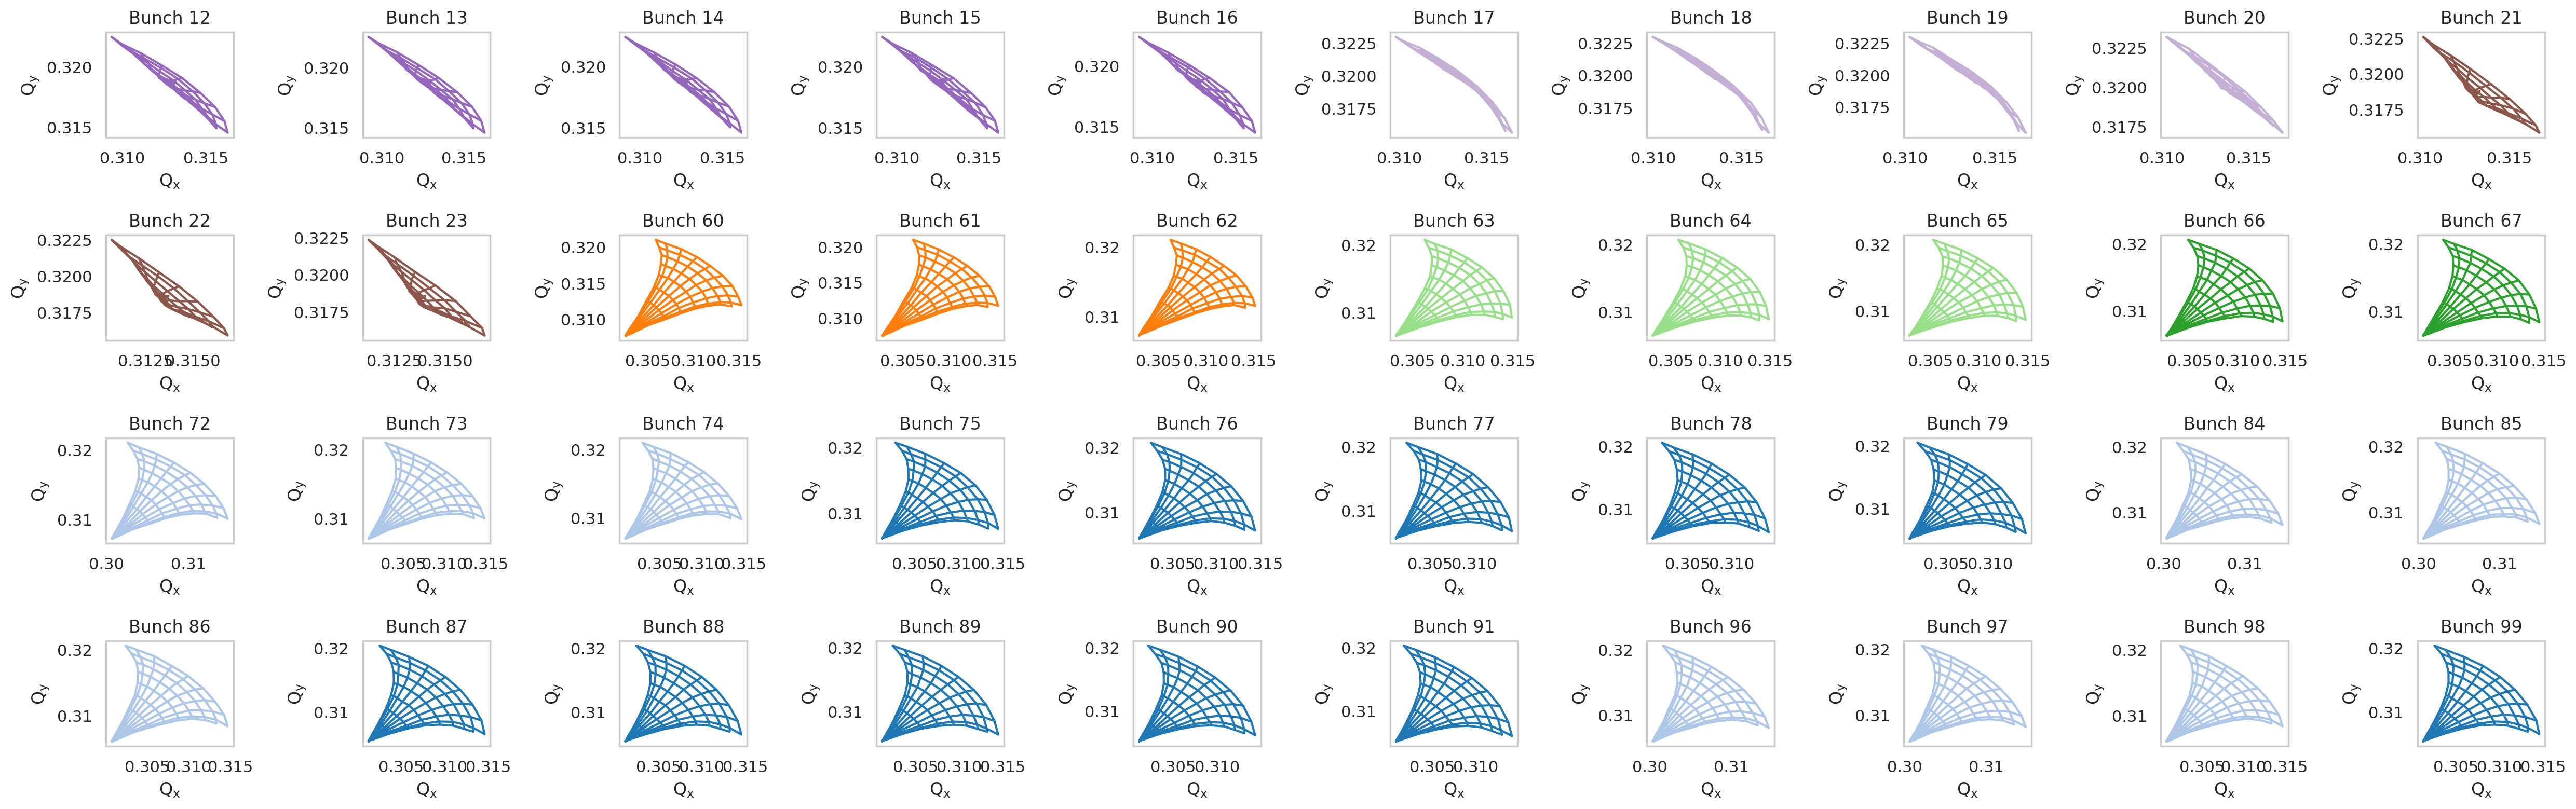

In [11]:
# Plot initial data according to labels
n_cols = 10
n_rows = int(np.ceil(len(l_fp[:sample_nb])/n_cols))
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*2.5, n_rows*2))
for i, fp in enumerate(l_fp[:sample_nb]):
    try:
        ax = axs[i//n_cols, i%n_cols]
        ax.plot(fp[0], fp[1], color="C" + str(clusterer.labels_[i]))
        ax.plot(fp[0].T, fp[1].T, color="C" + str(clusterer.labels_[i]))
        ax.set_title(f"Bunch {l_bunch_nb[i]}")
        ax.set_xlabel(r"$\mathrm{Q_x}$")
        ax.set_ylabel(r"$\mathrm{Q_y}$")
        #ax.set_aspect("equal")
        ax.set_title(f"Bunch {l_bunch_nb[i]}")
        ax.grid()
    except:
        pass

plt.tight_layout()
plt.show()

### Plot DA distribution per cluster

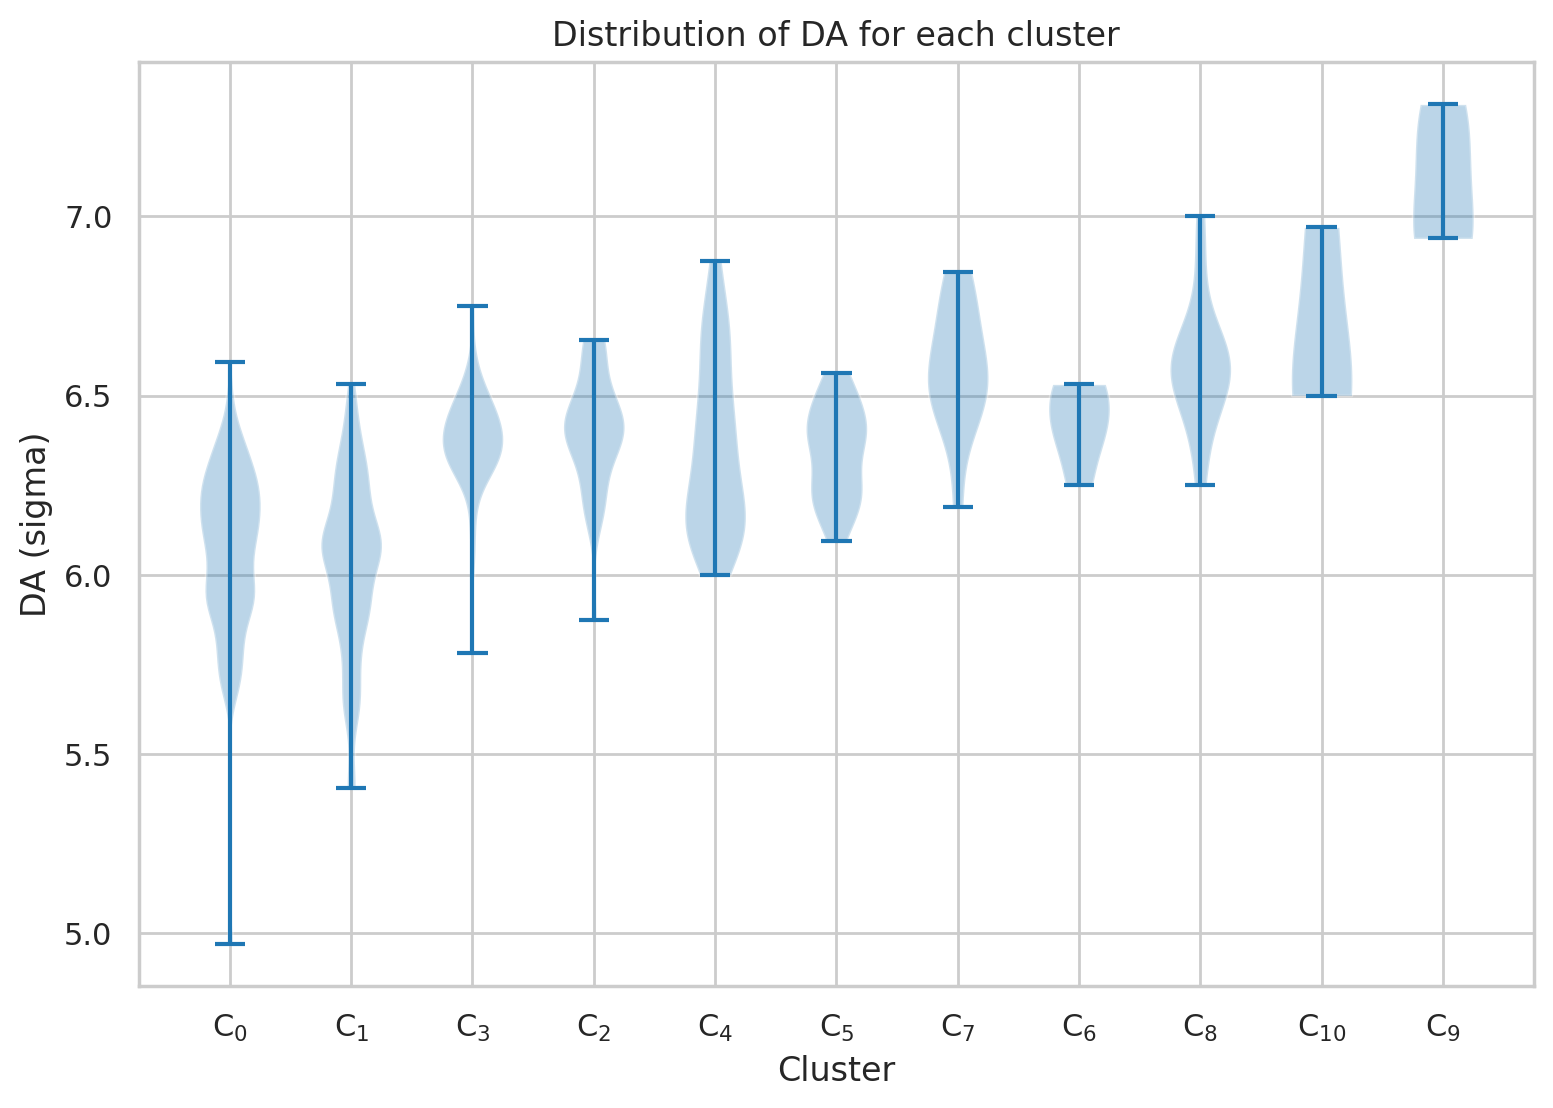

In [12]:
# Compute a dataframe of DA for each cluster

dic_cluster_DA = {f'C$_{{{i}}}$':[] for i in np.unique(clusterer.labels_)}
for i, bunch_nb in enumerate(l_bunch_nb):
    # Get cluster number
    cluster_nb = clusterer.labels_[i]
    dic_cluster_DA[f'C$_{{{cluster_nb}}}$'].append(dic_DA[bunch_nb])

# Get list of cluster numbers and list of DA for each cluster
l_cluster_nb = list(dic_cluster_DA.keys())
l_DA_violin = list(dic_cluster_DA.values())

# Sort by min DA in l_DA
l_DA_sorted = [x for _,x in sorted(zip([np.min(x) for x in l_DA_violin], l_DA_violin))]
l_cluster_nb_sorted = [x for _,x in sorted(zip([np.min(x) for x in l_DA_violin], l_cluster_nb))]

fig, ax = plt.subplots(figsize=(9, 6))

def set_axis_style(ax, labels):
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel('Cluster')

plt.violinplot(dataset=l_DA_sorted )
# set style for the axes
set_axis_style(ax, l_cluster_nb_sorted)
plt.ylabel("DA (sigma)")
plt.title("Distribution of DA for each cluster")
plt.savefig("PDF_output/DA_distribution.pdf")
plt.show()


### Build PDF files to represent all footprints

In [13]:
DO_PLOT_PDF = False

if DO_PLOT_PDF:
    # Build a file where footprints are colored by DA
    # Sample one bunch out of 10 to keep figure readable

    #Make a grid of plots for all the footprints
    n_cols = 10
    n_rows = int(np.ceil(len(l_fp_no_outlier[::10])/n_cols))
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*2.5, n_rows*2))
    #plt.suptitle("Footprints colored by DA")

    # Build a discrete colormap for DAs
    min_DA = np.min(l_DA)
    max_DA = np.max(l_DA)
    discrete_cmap = sns.color_palette("Spectral", n_colors=256)
    l_colors = [discrete_cmap[int((DA-min_DA)/(max_DA-min_DA)*255)] for DA in l_DA]
    dic_colors = {int(bunch_nb): color for bunch_nb, color in zip(l_bunch_nb_from_DA, l_colors)}


    # # Get ax limits
    min_x = np.min([np.nanmin(fp[0]) for fp in l_fp_no_outlier])
    max_x = np.max([np.nanmax(fp[0]) for fp in l_fp_no_outlier])
    min_y = np.min([np.nanmin(fp[1]) for fp in l_fp_no_outlier])
    max_y = np.max([np.nanmax(fp[1]) for fp in l_fp_no_outlier])

    for i, (bunch_nb, fp) in enumerate(zip(l_bunch_nb[::10], l_fp_no_outlier[::10])):
        ax = axs[i//n_cols, i%n_cols]
        ax.plot(fp[0], fp[1], color=dic_colors[bunch_nb])
        ax.plot(fp[0].T, fp[1].T, color=dic_colors[bunch_nb])
        ax.set_title(f"Bunch {bunch_nb}, DA={dic_DA[bunch_nb]:.3f}, cluster {clusterer.labels_[::10][i]}", fontsize=8)
        ax.set_xlabel(r"$\mathrm{Q_x}$", fontsize=6)
        ax.set_ylabel(r"$\mathrm{Q_y}$", fontsize=6)
        # Set smaller ticklabels
        ax.tick_params(axis='both', which='major', labelsize=6)
        ax.tick_params(axis='both', which='minor', labelsize=6)
        #ax.set_aspect("equal")
        ax.set_xlim(min_x-0.001, max_x+0.001)
        ax.set_ylim(min_y-0.001, max_y+0.001)
        #ax.set_title(f"Bunch {l_bunch_nb[i]}, DA={dic_DA[l_bunch_nb[i]]:.3f}, cluster {clusterer.labels_[i]}")
        ax.grid()

    plt.tight_layout()
    plt.savefig("PDF_output/footprints_colored_by_DA.pdf")


In [14]:
if DO_PLOT_PDF:

    # Build a file where footprints are colored by cluster
    # Sample one bunch out of 10 to keep figure readable

    #Make a grid of plots for all the footprints
    n_cols = 10
    n_rows = int(np.ceil(len(l_fp_no_outlier[::10])/n_cols))
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*2.5, n_rows*2))
    #plt.suptitle("Footprints colored by cluster")


    # # Get ax limits
    min_x = np.min([np.nanmin(fp[0]) for fp in l_fp_no_outlier])
    max_x = np.max([np.nanmax(fp[0]) for fp in l_fp_no_outlier])
    min_y = np.min([np.nanmin(fp[1]) for fp in l_fp_no_outlier])
    max_y = np.max([np.nanmax(fp[1]) for fp in l_fp_no_outlier])

    for i, (bunch_nb, fp) in enumerate(zip(l_bunch_nb[::10], l_fp_no_outlier[::10])):
        ax = axs[i//n_cols, i%n_cols]
        ax.plot(fp[0], fp[1],  color="C" + str(clusterer.labels_[::10][i]))
        ax.plot(fp[0].T, fp[1].T, color="C" + str(clusterer.labels_[::10][i]))
        ax.set_title(f"Bunch {bunch_nb}, DA={dic_DA[bunch_nb]:.3f}, cluster {clusterer.labels_[::10][i]}", fontsize=8)
        ax.set_xlabel(r"$\mathrm{Q_x}$", fontsize=6)
        ax.set_ylabel(r"$\mathrm{Q_y}$", fontsize=6)
        # Set smaller ticklabels
        ax.tick_params(axis='both', which='major', labelsize=6)
        ax.tick_params(axis='both', which='minor', labelsize=6)
        #ax.set_aspect("equal")
        ax.set_xlim(min_x-0.001, max_x+0.001)
        ax.set_ylim(min_y-0.001, max_y+0.001)
        #ax.set_title(f"Bunch {l_bunch_nb[i]}, DA={dic_DA[l_bunch_nb[i]]:.3f}, cluster {clusterer.labels_[i]}")
        ax.grid()

    plt.tight_layout()
    plt.savefig("PDF_output/footprints_colored_by_cluster.pdf")


### Use a neural network to predict DA with footprint

In [95]:
# First remove the perfectly identical footprints, by systematically comparing them all to each other
set_to_remove = set()
for i, (fp1, bunch_nb_1) in enumerate(zip(l_fp_no_outlier, l_bunch_nb)):
    for j, (fp2, bunch_nb_2) in enumerate(zip(l_fp_no_outlier[i+1:], l_bunch_nb[i+1:])):
        # If DAs are different, bunches are considered different
        if np.abs(dic_DA[bunch_nb_1] - dic_DA[bunch_nb_2]) > 1e-3:
            continue

        if np.allclose(fp1[0], fp2[0], equal_nan = True, rtol = 1e-3) and np.allclose(fp1[1], fp2[1], equal_nan = True, rtol = 1e-3):
            set_to_remove.add(j)

print(f"Removing {len(set_to_remove)} identical footprints")


Removing 904 identical footprints


In [96]:
# Get data
X = np.array([np.hstack(x) for j, x in enumerate(array_fp_flat) if j not in set_to_remove])
l_bunch_nb_no_similar = [x for j, x in enumerate(l_bunch_nb) if j not in set_to_remove]
y = np.array([dic_DA[bunch_nb] for bunch_nb in l_bunch_nb_no_similar])

In [97]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.ensemble import RandomForestRegressor

# Divide data between train and test
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=1)

# Center and reduce data
scaler = StandardScaler()  
# Don't cheat - fit only on training data
scaler.fit(X_train)  
X_train = scaler.transform(X_train)  
# apply same transformation to test data
X_test = scaler.transform(X_test)

# Build regressor and regress
# mlp = MLPRegressor(hidden_layer_sizes=(100, 100, 100, 100), max_iter=1000, alpha=0.1,
#                     solver='adam', verbose=10,  random_state=21).fit(X_train,y_train)
mlp = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=0).fit(X_train, y_train)

# Check result of test set
print("R2 score on train set: ", mlp.score(X_train, y_train))
print("R2 score on test set: ", mlp.score(X_test, y_test))





R2 score on train set:  0.6188215830680803
R2 score on test set:  0.489433364838476


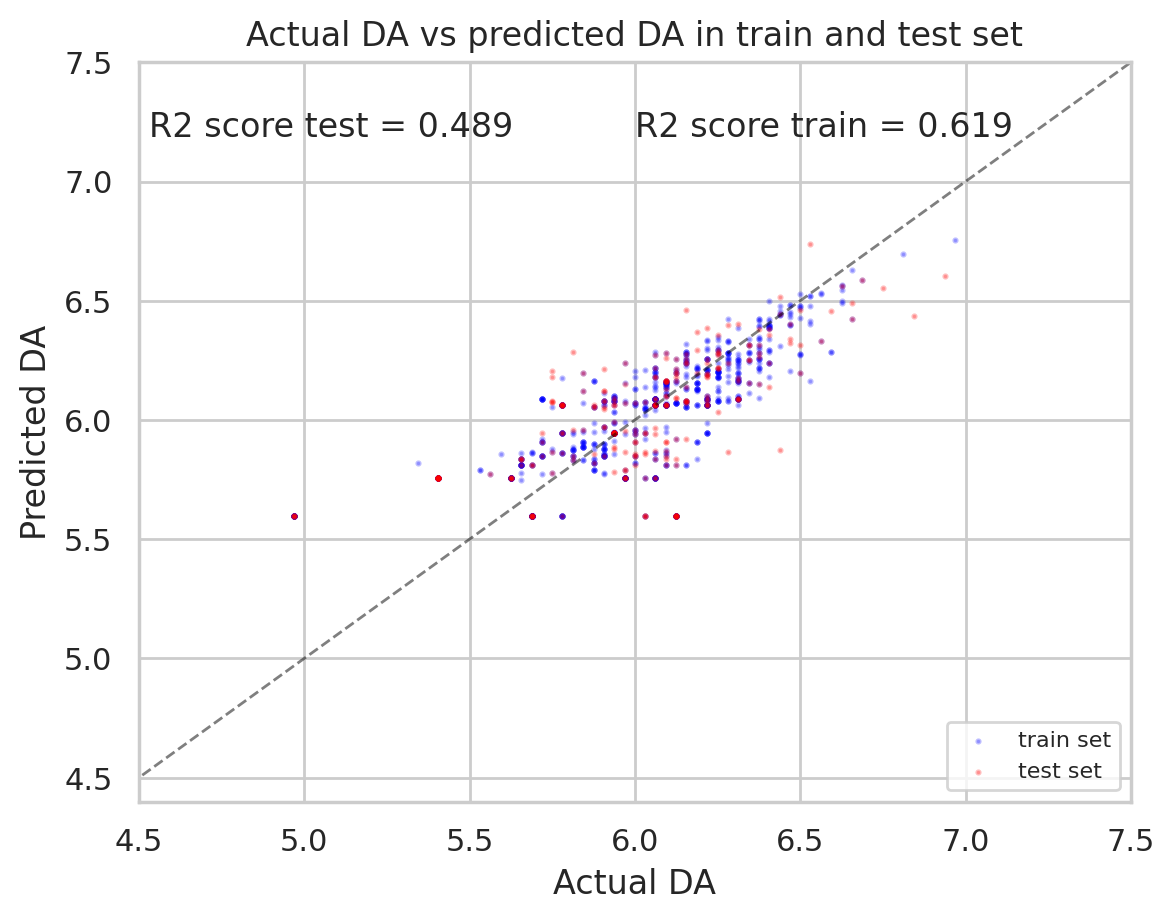

In [104]:
# Plot actual DA vs predicted DA in train and test sets
plt.figure()
plt.scatter(y_train, mlp.predict(X_train), s = 1.5, color = 'blue', alpha = 0.25, label = "train set")
plt.plot([0, 10], [0, 10], color='black', lw=1, linestyle='--', alpha=0.5)
plt.scatter(y_test, mlp.predict(X_test), s = 1.5, color = 'red', alpha = 0.25, label = "test set")

# Add R2 score
plt.text(0.5, 0.9, f"R2 score train = {mlp.score(X_train, y_train):.3f}", transform=plt.gca().transAxes)
plt.text(0.01, 0.9, f"R2 score test = {mlp.score(X_test, y_test):.3f}", transform=plt.gca().transAxes)

plt.xlabel("Actual DA")
plt.ylabel("Predicted DA")
plt.title("Actual DA vs predicted DA in train and test set")
plt.xlim(4.5, 7.5)
plt.ylim(4.4, 7.5)
# Position legend at bottom right
plt.legend(loc = "lower right", fontsize = 8)
plt.show()


# plt.figure()
# plt.plot([0, 10], [0, 10], color='black', lw=1, linestyle='--', alpha=0.5)
# # Add R2 score
# plt.xlabel("Actual DA")
# plt.ylabel("Predicted DA")
# plt.title("Actual DA vs predicted DA in test set")
# plt.xlim(4.5, 7.5)
# plt.ylim(4.4, 7.5)
# plt.show()